# **Final Exam for Deep Network Development course. First part (mandatory)**

This notebook contains the task to be solved in order to pass the exam.
This is the first part of the exam, which is compolsury in order to get a grade. It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function.

Please note that, to **PASS** the Deep Network Development course you must **SUBMIT A SUCCESSFUL SOLUTION FOR THE FIRST PART**. If you **FAIL** the first part, you have the right to do the exam **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course. If you **PASS** the first part, then you get the weighted average of your quizzes and assignments as your final grade.

## Your information
Please fill the next cell with your information

**Full Name**:

**Neptun code:**

**Date:** 09/01/2024 9AM-10AM

## Task Description

#### Your task is to implement a custom architecture inspired by a image-to-image Diffusion like model, and the forward function. The model receives an intial image and a text as input (describes how the final image should look like) and generates an image according to the two.

#### Afterwards, make sure to run cell code number 1.2. to check if your implementation is correct.

#### This task should be **SOLVED IN 1 HOUR** and submitted to Canvas (download the .ipynb file). Please note that after 1 hour, the Canvas exam assignment will be closed and you cannot submit your solution.

In [464]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### **NO GPU IS NEEDED for this task**. No training nor any computationally expensive operation will be performed. This notebook runs on any computer using a cpu.

In [465]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device

## 1. Architecture

#### Please keep in mind that this architecture is purely imagined and should not correspond to any existing model / architecture. You will not find it on the internet.

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/11gey3SssCJe6CIUiFON9e-eoLdkegDna/view?usp=drive_link

<br>
<br>

![](https://drive.google.com/uc?export=view&id=11gey3SssCJe6CIUiFON9e-eoLdkegDna)

#### Input image

In [466]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((256, 256))
image = np.rollaxis(np.array(image), 2, 0)

In [467]:
image.shape

(3, 256, 256)

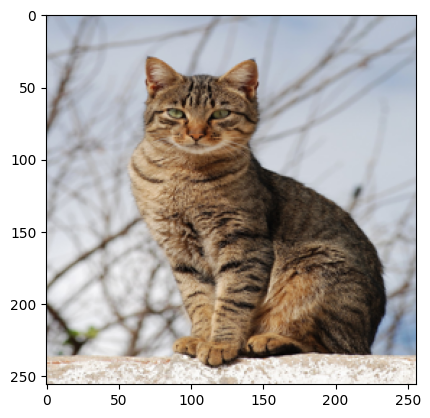

In [468]:
plt.imshow(np.moveaxis(image, 0,-1))

In [469]:
#Simple pre-processing
input_image = torch.tensor(image,dtype=torch.float32)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

torch.Size([1, 3, 256, 256])

#### Input text

In [470]:
text = "A cat wearing sunglasses and suit"

# Simple preprocessing the text
word_to_ix = {"A": 0, "cat": 1, "wearing": 2, "sunglasses": 3, "and": 4, "suit": 5}
lookup_tensor = torch.tensor(list(word_to_ix.values()), dtype=torch.long) # a tensor representing words by integers

vocab_size = len(lookup_tensor)

In [471]:
vocab_size

6

#### 1.1. Implement the architecture

In [472]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channels):
        super(TextEncoder, self).__init__()

        # DEFINE the layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.deconv1 = nn.ConvTranspose2d(vocab_size, out_channels, kernel_size=4, stride=4, padding=0)
        
    def forward(self, input_text):
        # EMBED the input text
        embeddings = self.embeddings(input_text)        
        print(f'TextEncoder - embeddings shape: {embeddings.shape}')  # [6, 1024]

        # RESHAPE the embeddings and SEND them to the next layer
        embeddings = embeddings.view(1,6,32,32)              
        print(f'TextEncoder - embeddings shape: {embeddings.shape}')  # [1, 6, 32, 32]

        # SEND the reshaped embeddings to the next layer
        x = self.deconv1(embeddings)
        print(f'TextEncoder shape: {x.shape}') 

        return x

class ImageEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageEncoder, self).__init__()
        # DEFINE the layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input_image):
        # SEND the input image and then the features to the given layers
        conv1 = self.conv1(input_image)
        conv1 = F.relu(conv1)
        conv2 = self.conv2(conv1)
        conv2 = F.relu(conv2)
        x = self.bn3(conv2)
        print(f'ImageEncoder shape: {x.shape}')
        return x

class ImageDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageDecoder, self).__init__()
        # DEFINE the layers
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.deconv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, image_features):
        # SEND the image features to the given layers
        bn1 = self.bn1(image_features)
        print(f'bn1 shape: {bn1.shape}')
        deconv1 = self.deconv1(bn1)
        print(f'deconv1 shape: {deconv1.shape}')
        x = F.relu(deconv1)
        return x

class MyUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyUNet, self).__init__()
        # DEFINE the layers
        self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=3, padding='same')         # [1, 128, 128, 128]
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)                                # [1, 128, 64, 64]
        self.conv3 = nn.Conv2d(128, 256, kernel_size=2, padding='same')                 # [1, 256, 64, 64]
        self.conv4 = nn.Conv2d(256, 64, kernel_size=4, padding='same')                  # [1, 64, 64, 64]
        self.deconv5 = nn.ConvTranspose2d(320, 128, kernel_size=4, stride=2, padding=1) # [1, 128, 128, 128]
        self.conv6 = nn.Conv2d(256, out_channels, kernel_size=3, padding='same')        # [1, 3, 128, 128]

    def forward(self, combined_features):
        # SEND the combined features to the given layers of the downscaling part of the U-Net
        conv1 = self.conv1(combined_features)
        print(f'MyUNet - conv1 shape: {conv1.shape}')
        conv1 = F.relu(conv1)

        mp2 = self.mp2(conv1)
        print(f'MyUNet - mp2 shape: {mp2.shape}')
        conv3 = self.conv3(mp2)
        print(f'MyUNet - conv3 shape: {conv3.shape}')
        conv3 = F.relu(conv3)

        conv4 = self.conv4(conv3)
        print(f'MyUNet - conv4 shape: {conv4.shape}')
        conv4 = F.relu(conv4)        
        
        # COMBINE the features before you send them to the ConvTranspose2d layer of the U-Net
        concat1 = torch.cat((conv3, conv4), dim=1)
        print(f'MyUNet - concat1 shape: {concat1.shape}')

        # SEND the COMBINED features to the ConvTranspose2d layer
        deconv5 = self.deconv5(concat1)
        print(f'MyUNet - deconv5 shape: {deconv5.shape}')

        # COMBINE the features again before you send them to the last Conv2d layer of the U-Net
        concat2 = torch.cat((conv1, deconv5), dim=1)
        print(f'MyUNet - concat2 shape: {concat2.shape}')

        # SEND the COMBINED features to the last Conv2d and ReLU layer of the U-Net
        conv6 = self.conv6(concat2)
        print(f'MyUNet shape: {conv6.shape}')

        x = F.relu(conv6)
        return x

class ImageToImageGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels):
        super(ImageToImageGenerator, self).__init__()
        # DEFINE the TEXT ENCODER, IMAGE ENCODER, U-NET, and IMAGE DECODER
        self.text_encoder = TextEncoder(vocab_size, embedding_dim, text_encoder_out_channels)
        self.image_encoder = ImageEncoder(image_channels, image_encoder_out_channels)
        self.unet = MyUNet(text_encoder_out_channels + image_encoder_out_channels, unet_out_channels)
        self.image_decoder = ImageDecoder(unet_out_channels, image_channels)
        
    def forward(self, input_text, input_image):
        # SEND the input text to the TEXT ENCODER
        text_encoder = self.text_encoder(input_text)

        # SEND the input image to the IMAGE ENCODER
        image_encoder = self.image_encoder(input_image)

        # COMBINE the TEXT FEATURES form the TEXT ENCODER and IMAGE FETURES from the IMAGE ENCODER
        combined_features = torch.cat((text_encoder, image_encoder), dim=1)

        # SEND the COMBINED FETURES to the U-NET
        unet = self.unet(combined_features)

        # SEND the IMAGE FETURES from the U-NET to the IMAGE DECODER
        generated_image = self.image_decoder(unet)

        return generated_image
    


#### 1.2. Test your implementation
Expected output

torch.Size( [1, 3, 256, 256] )

In [473]:
embedding_dim = 1024
image_channels = 3
text_encoder_out_channels = 32
image_encoder_out_channels = 64
unet_out_channels = 64
model = ImageToImageGenerator(vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels)

input_text = lookup_tensor

# Forward pass
output = model(input_text, input_image)
print('----------------------------------------------------------------')
print("Output Image Shape:", output.shape)

TextEncoder - embeddings shape: torch.Size([6, 1024])
TextEncoder - embeddings shape: torch.Size([1, 6, 32, 32])
TextEncoder shape: torch.Size([1, 32, 128, 128])
ImageEncoder shape: torch.Size([1, 64, 128, 128])
MyUNet - conv1 shape: torch.Size([1, 128, 128, 128])
MyUNet - mp2 shape: torch.Size([1, 128, 64, 64])
MyUNet - conv3 shape: torch.Size([1, 256, 64, 64])
MyUNet - conv4 shape: torch.Size([1, 64, 64, 64])
MyUNet - concat1 shape: torch.Size([1, 320, 64, 64])
MyUNet - deconv5 shape: torch.Size([1, 128, 128, 128])
MyUNet - concat2 shape: torch.Size([1, 256, 128, 128])
MyUNet shape: torch.Size([1, 64, 128, 128])
bn1 shape: torch.Size([1, 64, 128, 128])
deconv1 shape: torch.Size([1, 3, 256, 256])
----------------------------------------------------------------
Output Image Shape: torch.Size([1, 3, 256, 256])


For fun -- check the generated image, it should look something like this: https://drive.google.com/file/d/1qCCmxt5FKdOrGrFkajti9_UFvZAPaSHA/view?usp=sharing

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1qCCmxt5FKdOrGrFkajti9_UFvZAPaSHA)


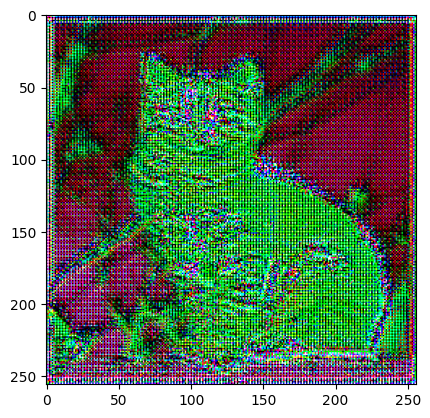

In [474]:
%matplotlib inline

rgb_array = output[0].permute(1, 2, 0).detach().numpy()
rgb_array = rgb_array.clip(0, 1)
plt.imshow(rgb_array)